In [1]:
import os
import sys
import shutil

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import region_formatter, path_utils

In [4]:
pathUtils = path_utils.PathUtils()

In [5]:
fig_plots = []

In [6]:
git_root_path = pathUtils.get_git_root(os.getcwd())
dataframes_path = "{}/dataframes".format(git_root_path)

In [7]:
%run ../dataframes/provinces_gdf.ipynb -i
provinces_gdf = pd.read_pickle("{}/provinces_gdf.pkl".format(dataframes_path))

In [8]:
%run ../dataframes/asl.ipynb -i
df_asl = pd.read_pickle("{}/df_asl.pkl".format(dataframes_path))

In [9]:
%run ../dataframes/dism_first_access.ipynb -i
df_dism_first_access = pd.read_pickle("{}/df_dism_first_access.pkl".format(dataframes_path))

In [10]:
newcmp = LinearSegmentedColormap.from_list("", ["#a3b18a", "#588157","#3a5a40"])

In [11]:
### Constants
OUTPUT_DIR = "output"
TARGET_GROUP = "Depressione"
TARGET_GROUP_TEXT = "Depressione"
YEAR = "2022"
# CMAP = (ListedColormap(['cyan', 'yellow', 'orange']))
CMAP = newcmp

In [12]:
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True

In [13]:
REGION_COLOURS = {
    "Nord": "#344e41", 
    "Centro": "#588157",
    "Sud e Isole": "#dad7cd",
}

In [14]:
if not os.path.exists(OUTPUT_DIR):
    # Create the directory
    os.makedirs(OUTPUT_DIR)

In [15]:
folder = OUTPUT_DIR
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# prepare dataframe

In [16]:
df = df_dism_first_access.loc[df_dism_first_access["gruppo_diagnostico"] == TARGET_GROUP, [
    "codice_asl", 
    "descrizione_regione",
    "sesso",
    "numero_accessi"
] ]

In [17]:
df

,codice_asl,descrizione_regione,sesso,numero_accessi
4,203,PIEMONTE,Maschio,1606
15,203,PIEMONTE,Femmina,3129
26,204,PIEMONTE,Maschio,1557
37,204,PIEMONTE,Femmina,2785
48,205,PIEMONTE,Maschio,549
...,...,...,...,...
2865,305,SARDEGNA,Femmina,344
2875,306,SARDEGNA,Maschio,70
2884,306,SARDEGNA,Femmina,128
2894,308,SARDEGNA,Maschio,604


In [18]:
df_asl = df_asl[["codice_azienda", "sigla_provincia"]]

In [19]:
df_asl

,codice_azienda,sigla_provincia
0,201,TO
1,202,TO
2,203,TO
3,204,TO
4,205,TO
...,...,...
1801,304,NU
1802,305,OR
1803,306,SU
1804,307,SU


In [46]:
df_asl.loc[df_asl["codice_azienda"] == 203, ]

,codice_azienda,sigla_provincia
2,203,TO
105,203,PE
110,203,CE
126,203,CZ
131,203,CT
...,...,...
1760,203,RM
1766,203,PE
1771,203,CE
1786,203,CZ


In [21]:
provinces_gdf = provinces_gdf[["prov_acr", "geometry", "zone", "prov_name"]]

In [22]:
df = df.set_index("codice_asl").join(df_asl.set_index("codice_azienda"))

In [23]:
df.loc[df["sigla_provincia"] == "RM", ]

,descrizione_regione,sesso,numero_accessi,sigla_provincia
codice_asl,,,,
203,PIEMONTE,Maschio,1606,RM
203,PIEMONTE,Maschio,1606,RM
203,PIEMONTE,Maschio,1606,RM
203,PIEMONTE,Maschio,1606,RM
203,PIEMONTE,Maschio,1606,RM
...,...,...,...,...
206,SICILIA,Femmina,4016,RM
206,SICILIA,Femmina,4016,RM
206,SICILIA,Femmina,4016,RM


In [24]:
df_asl_agg = df_asl.pivot_table(
    index='sigla_provincia',
    aggfunc='count',
)

In [25]:
df_asl_agg

,codice_azienda
sigla_provincia,
AG,15
AL,15
AN,15
AO,15
AP,2
...,...
VI,44
VR,29
VS,7


In [26]:
df_asl_agg = df_asl_agg.rename(columns={
    "codice_azienda": "asl_count",
})

In [27]:
df = df.reset_index()

In [28]:
df = df.pivot_table(
    index='sigla_provincia',
    aggfunc='sum',
    values='numero_accessi'
)

In [29]:
df

,numero_accessi
sigla_provincia,
AG,1172475
AL,36030
AN,1016145
AO,279300
AP,918
...,...
VI,566707
VR,54144
VS,39221


In [30]:
df = df.join(df_asl_agg)

In [31]:
df = df.assign(target_group_avg=lambda df_: df_.numero_accessi / df_.asl_count)

In [32]:
df

,numero_accessi,asl_count,target_group_avg
sigla_provincia,,,
AG,1172475,15,78165.000000
AL,36030,15,2402.000000
AN,1016145,15,67743.000000
AO,279300,15,18620.000000
AP,918,2,459.000000
...,...,...,...
VI,566707,44,12879.704545
VR,54144,29,1867.034483
VS,39221,7,5603.000000


In [33]:
df = provinces_gdf.set_index("prov_acr").join(df)

In [34]:
df

,geometry,zone,prov_name,numero_accessi,asl_count,target_group_avg
prov_acr,,,,,,
TO,"POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...",Nord,Torino,2159347.0,67.0,32229.059701
VC,"POLYGON ((7.92900 45.74244, 7.92584 45.74196, ...",Nord,Vercelli,371895.0,15.0,24793.000000
NO,"POLYGON ((8.42079 45.82981, 8.42028 45.83010, ...",Nord,Novara,88995.0,15.0,5933.000000
CN,"MULTIPOLYGON (((6.94540 44.42794, 6.94734 44.4...",Nord,Cuneo,90735.0,30.0,3024.500000
AT,"POLYGON ((7.96685 45.11667, 7.96729 45.11673, ...",Nord,Asti,30000.0,15.0,2000.000000
...,...,...,...,...,...,...
SS,"MULTIPOLYGON (((9.46502 40.65584, 9.46475 40.6...",Sud e Isole,Sassari,548459.0,18.0,30469.944444
NU,"MULTIPOLYGON (((9.28037 39.91741, 9.27741 39.9...",Sud e Isole,Nuoro,175412.0,13.0,13493.230769
CA,"MULTIPOLYGON (((8.84872 39.09924, 8.84697 39.1...",Sud e Isole,Cagliari,5889.0,10.0,588.900000


In [35]:
plot_title = "Totale accessi con diagnosi '{}'\n per DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

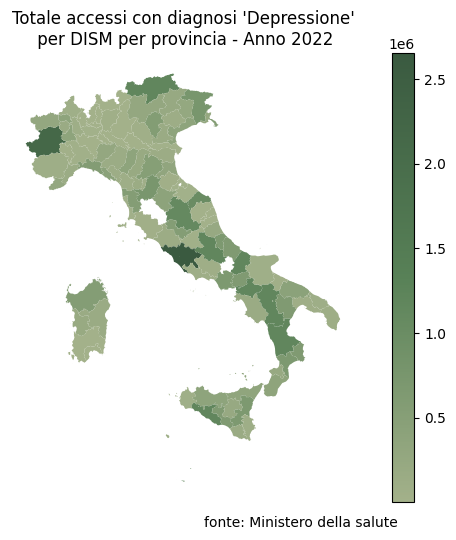

In [36]:
df_plot = df.plot(
    column="numero_accessi",
    legend=True,
    cmap=CMAP
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

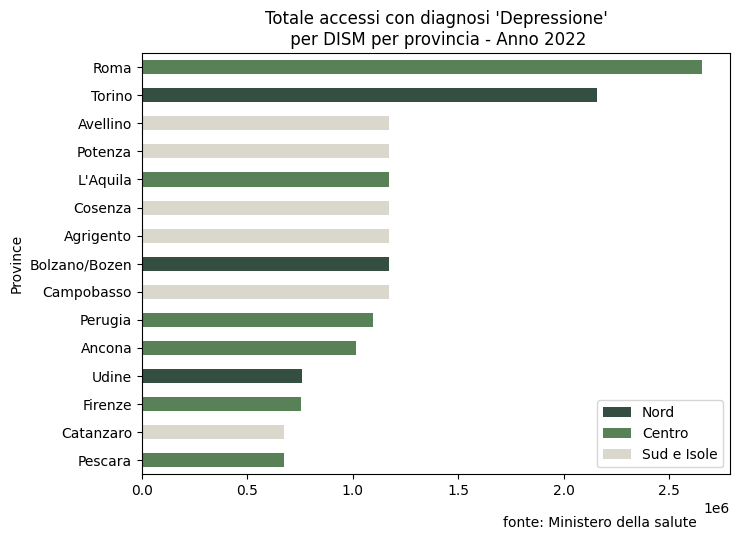

In [37]:
best_rows = df.sort_values(by=['numero_accessi'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['numero_accessi'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    y="numero_accessi",
    x="prov_name",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [38]:
best_rows

,geometry,zone,prov_name,numero_accessi,asl_count,target_group_avg
prov_acr,,,,,,
RM,"MULTIPOLYGON (((11.82281 42.14649, 11.82464 42...",Centro,Roma,2655276.0,102.0,26032.117647
TO,"POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...",Nord,Torino,2159347.0,67.0,32229.059701
CB,"POLYGON ((14.41933 41.43515, 14.41251 41.44122...",Sud e Isole,Campobasso,1172475.0,15.0,78165.000000
BZ,"POLYGON ((11.47690 46.36393, 11.47769 46.36325...",Nord,Bolzano/Bozen,1172475.0,15.0,78165.000000
AG,"MULTIPOLYGON (((13.66344 37.19338, 13.66190 37...",Sud e Isole,Agrigento,1172475.0,15.0,78165.000000
CS,"MULTIPOLYGON (((15.97395 39.46742, 15.97243 39...",Sud e Isole,Cosenza,1172475.0,15.0,78165.000000
AQ,"POLYGON ((13.94102 41.68797, 13.94048 41.68817...",Centro,L'Aquila,1172475.0,15.0,78165.000000
PZ,"MULTIPOLYGON (((16.04822 40.63557, 16.04839 40...",Sud e Isole,Potenza,1172475.0,15.0,78165.000000
AV,"POLYGON ((14.76034 41.00938, 14.76379 41.00967...",Sud e Isole,Avellino,1172475.0,15.0,78165.000000


In [39]:
plot_title = "Media accessi con diagnosi '{}'\n per DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

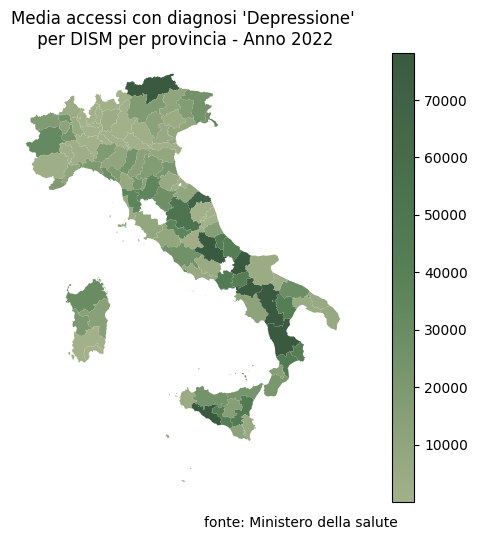

In [40]:
df_plot = df.plot(
    column="target_group_avg",
    legend=True,
    cmap=CMAP
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

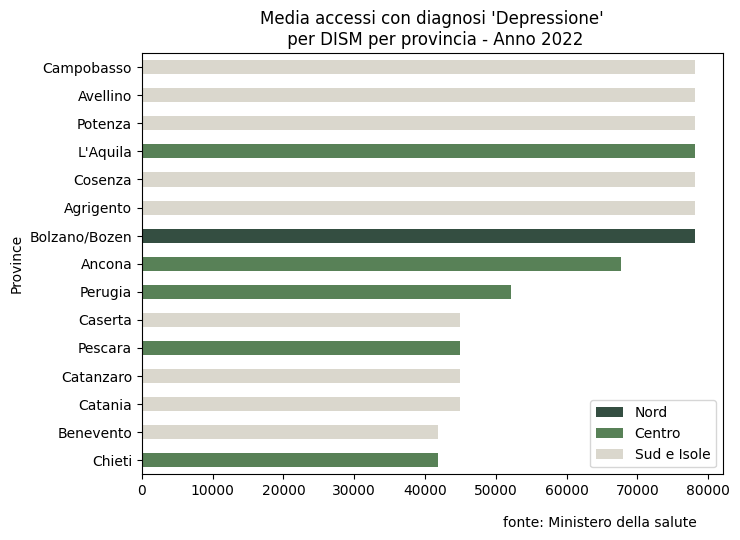

In [41]:
best_rows = df.sort_values(by=['target_group_avg'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['target_group_avg'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    x="prov_name",
    y="target_group_avg",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [42]:
plot_title = "Numero di DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

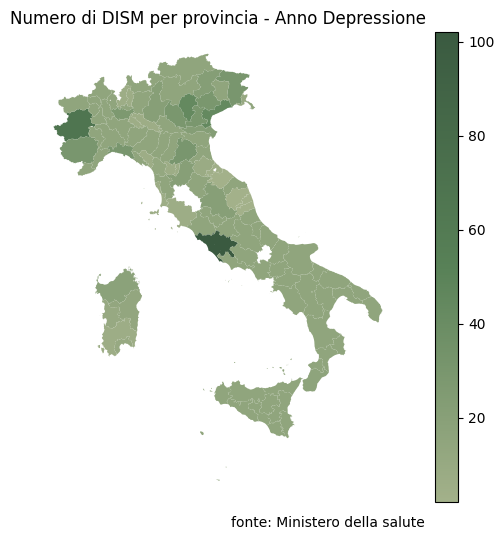

In [43]:
df_plot = df.plot(
    column="asl_count",
    legend=True,
    cmap=CMAP
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

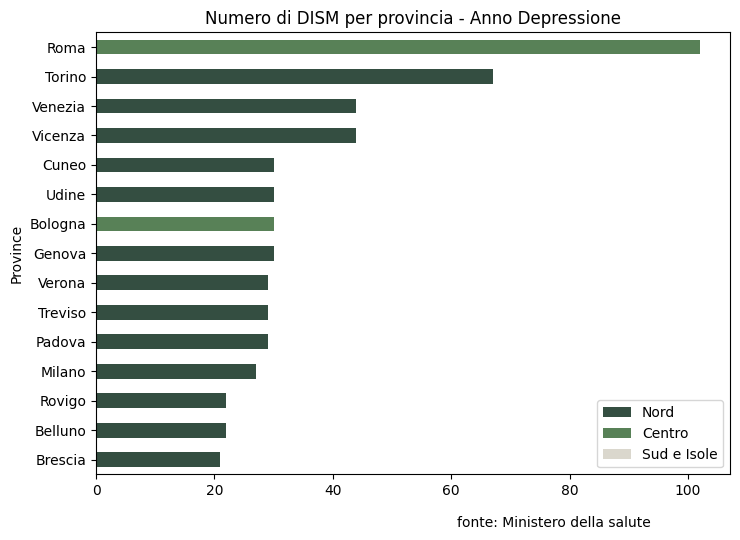

In [44]:
best_rows = df.sort_values(by=['asl_count'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['asl_count'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    x="prov_name",
    y="asl_count",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [45]:
for i, fig_plot in enumerate(fig_plots, start=1):
    df_ = fig_plot.get("df")
    df_name = fig_plot.get("name")
    file_name = "{}/{}_{}.png".format(OUTPUT_DIR, i, df_name)
    df_.get_figure().savefig(file_name)